# Seq2Seq Language Translation model, word level model

### Rosie Nguyen

See Datasets: http://www.manythings.org/anki/

### Import Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

### Load the data

In [ ]:
#load raw text data file.
df=pd.read_csv('vie.txt',delimiter="\t", header=None)
#name the columns
df.columns = ['English', 'Vietnamese', 'Others']
df.head()

,English,Vietnamese,Others
0,Run!,Chạy!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
1,Help!,Giúp tôi với!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
2,Go on.,Tiếp tục đi.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hello!,Chào bạn.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
4,Hurry!,Nhanh lên nào!,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


### Data Preprocessing

**Remove unnecessary columns, shuffle rows but keep the correlatio between English and Vietnamese columns**

In [ ]:
#remove column others
df= df.drop(columns= 'Others') 
#shuffle the rows but still keep the correct translation orders
df= df.reindex(np.random.permutation(df.index))
df.head(10)

,English,Vietnamese
6340,Tom has been missing for almost three weeks.,Tom đã mất tích gần ba tuần nay.
5200,You should've come a little earlier.,Đáng lẽ ra bạn nên tới sớm hơn một chút.
42,She cried.,Cô ấy đã khóc
508,I have two books.,Tôi có hai cuốn sách.
2026,I'm still not buying it.,Tôi vẫn không tin điều đó.
138,I'm innocent.,Tôi trong sạch!
6023,Do you think Tom really enjoys doing that?,Cậu có nghĩ Tom thực sự thích việc đó không?
2286,I got on the wrong train.,Tớ lên nhầm tàu.
6540,There are a few magazines on the coffee table.,Có vài quyển tạp chí trên cái bàn uống cafe đó.
4355,You're not allowed to camp here.,Anh không được phép cắm trại ở đây.


**Text processing: convert to lowercase, remove punctuation, remove whitespaces at the start and end of sentences**

In [ ]:
#text preprocessing
eng_lines = df['English'].values
viet_lines = df['Vietnamese'].values

#convert to lowercase
eng_lines = [x.lower() for x in eng_lines]
viet_lines = [x.lower() for x in viet_lines]

#create remove_punc to remove puntuation
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentence = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentence))
  return removed_punc_text
#use remove_punc on eng and viet
eng_lines = remove_punc(eng_lines)
viet_lines = remove_punc(viet_lines)

# removing the digits from english and vietnamese sentences
remove_digits = str.maketrans('', '', digits)
removed_digits_eng = []
removed_digits_viet = []
for sent in eng_lines:
  sentence = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_eng.append(' '.join(sentence))
eng_lines = removed_digits_eng

for sent in viet_lines:
  sentence = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_viet.append(' '.join(sentence))
viet_lines = removed_digits_viet

#removing the starting and ending whitespaces
eng_lines = [x.strip() for x in eng_lines]
viet_lines = [x.strip() for x in viet_lines]

# Putting the "<START> " and " <END>" in the vietnamese sentences for effective model training
viet_lines = ["START " + x + " END" for x in viet_lines]
#print(viet_lines)

**Compute the vocabulary for both English and Vietnamese**

In [ ]:
# Vocabulary of English
eng_words=set()
for eng in eng_lines:
    for word in eng.split():
        if word not in eng_words:
            eng_words.add(word)

# Vocabulary of Vietnamese
viet_words=set()
for viet in viet_lines:
    for word in viet.split():
        if word not in viet_words:
            viet_words.add(word)
#print(eng_words)
#print(viet_words)

In [ ]:
# Max Length of source sequence
lenght_list=[]
for l in eng_lines:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
print('Max length of source sequence is',  max_length_src)
# Max Length of target sequence
lenght_list=[]
for l in viet_lines:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
print('Max length of target sequence is', max_length_tar)
input_words = sorted(list(eng_words))
target_words = sorted(list(viet_words))
#print(input_words)
#print(target_words)

Max length of source sequence is 32
Max length of target sequence is 41


In [ ]:
# Calculate Vocab size for both source and target
num_encoder_tokens = len(eng_words)+1
num_decoder_tokens = len(viet_words)+1  

print('Vocab size for source is', num_encoder_tokens)
print('Vocab size for target is', num_decoder_tokens)
# Create word to token dictionary for both source and target
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])
#print(input_token_index)

# Create token to word dictionary for both source and target
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
#print(reverse_input_char_index)

Vocab size for source is 3664
Vocab size for target is 2319


**Splitting the data**

In [ ]:
#Splitting the data 90:10 for training: test
X = eng_lines
Y = viet_lines

#Splitting the data 90:10 for training: test
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

6802
6802
756
756


**A sentence can be seen as a sequence of either words or characters. For example in case of words, the English sentence "this is deep learning class" can be thought of as a sequence of 5 words (‘this’, ‘is’, ‘deep’, ‘learning’, ‘class’). And in case of characters, it can be thought of as a sequence of 18 characters (‘t’, ‘h’, ‘i’, ‘s’, ‘i’, ‘s ‘, ……, ‘s’).**

### Build a word level model

The word level language model predict the next word given all previous words in a sequence of data

In [ ]:
#generator function to load the data in batches
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
latent_dim = 256
# Encoder
encoder_inputs = Input(shape=(None,),name="encoder_inputs")
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard 'encoder_outputs' and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using 'encoder_states' as initial state.
decoder_inputs = Input(shape=(None,),name="decoder_inputs")
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Use a softmax to generate a probability distribution over the target vocabulary for each time step
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the word model that will turn encoder_input_data & decoder_input_data into decoder_target_data
word_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Compile the model
word_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
word_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    937984      encoder_inputs[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    593664      decoder_inputs[0][0]             
______________________________________________________________________________________________

In [ ]:
plot_model(word_model, to_file='train_word_model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
#Fit the word model
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

history= word_model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs)

Epoch 1/100


C:\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


53/53 [==============================] - 69s 1s/step - loss: 1.3066 - acc: 0.1365
Epoch 2/100
53/53 [==============================] - 83s 2s/step - loss: 1.1858 - acc: 0.1523
Epoch 3/100
53/53 [==============================] - 62s 1s/step - loss: 1.1405 - acc: 0.1691
Epoch 4/100
53/53 [==============================] - 74s 1s/step - loss: 1.0916 - acc: 0.1880
Epoch 5/100
53/53 [==============================] - 120s 2s/step - loss: 1.0421 - acc: 0.2150
Epoch 6/100
53/53 [==============================] - 118s 2s/step - loss: 0.9916 - acc: 0.2447
Epoch 7/100
53/53 [==============================] - 162s 3s/step - loss: 0.9546 - acc: 0.2610
Epoch 8/100
53/53 [==============================] - 92s 2s/step - loss: 0.9173 - acc: 0.2778
Epoch 9/100
53/53 [==============================] - 97s 2s/step - loss: 0.8833 - acc: 0.2945
Epoch 10/100
53/53 [==============================] - 114s 2s/step - loss: 0.8507 - acc: 0.3104
Epoch 11/100
53/53 [==============================] - 134s 3s/step 

In [ ]:
print("Accuracy of the Word Level Model = ",max(history.history["acc"]))
print("Loss of the Word Level Model = ",max(history.history["loss"]))

Accuracy of the Word Level Model =  0.9792900681495667
Loss of the Word Level Model =  1.3066120147705078


**Saving the model into Json**

In [ ]:
model_json = word_model.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
word_model.save_weights("model_weight_5.h5")
print("Saved word model to disk")

Saved word model to disk


**Loading the model and weight from Json**

In [ ]:
# loading the model architecture and asigning the weights
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("model_weight_5.h5")

**Plot results of accuracy**

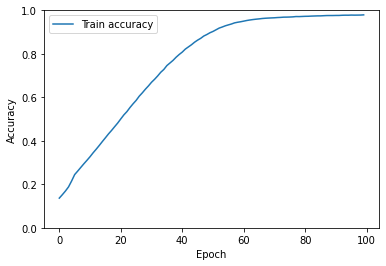

In [ ]:
def plot_history(history,key='acc'):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['acc']),
           label='Train accuracy')
  plt.legend()
  plt.ylim([0, 1])

plot_history(history)

**Plot results of loss**

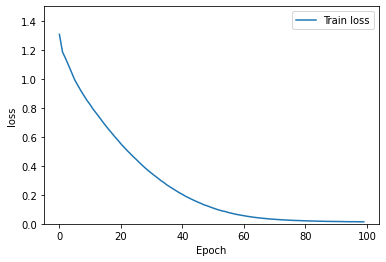

In [ ]:
def plot_history2(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train loss')
  plt.legend()
  plt.ylim([0, 1.5])

plot_history2(history)

### Prediction using Word Level Model

**Inference Setup**

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         937984    
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,463,296
Trainable params: 1,463,296
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Code to predict the input sentences translation
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START']
    #print("target_seq:=>",target_seq)
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'END' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [ ]:
def tokenizer_(text_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_data)
  return tokenizer

tokenizer_input = tokenizer_(X_train)

for i in range(30):
  sentence = X_test[i]
  original_target = y_test[i]
  #input_seq = target_token_index.texts_to_sequences([sentence])
  input_seq = tokenizer_input.texts_to_sequences([sentence])
  pad_sequence = pad_sequences(input_seq, maxlen= 30, padding='post')
  predicted_target = decode_sequence(pad_sequence)
  print("Test sentence: ",i+1)
  print("sentence: ",sentence)
  print("original translate:",original_target[6:-4]) #don't print start and end
  print("predicted Translate:",predicted_target[:-4]) ##don't print end
  print("=="*50)

Test sentence:  1
sentence:  this isnt the first time ive ridden a bicycle
original translate: đây không phải là lần đầu tôi đi xe đạp
predicted Translate:  ngày qua được sinh ra cho chó vào trang
Test sentence:  2
sentence:  do you have a brother
original translate: bạn có anhem trai không
predicted Translate:  đừng để chúng ta đi ngủ
Test sentence:  3
sentence:  i have some time
original translate: có có một ít thời gian
predicted Translate:  đi bộ cho chuyện đó đang tìm một cách
Test sentence:  4
sentence:  he never tells lies
original translate: nó không bao giờ nói láo
predicted Translate:  anh ấy đang đọc sách
Test sentence:  5
sentence:  all of us were silent
original translate: tất cả chúng tôi đều đã im lặng
predicted Translate:  bạn hãy gọi tôi trong thư để tiết kiệm
Test sentence:  6
sentence:  tom demanded an apology
original translate: tom yêu cầu một lời xin lỗi
predicted Translate:  tôi biết cô ấy ở đâu
Test sentence:  7
sentence:  im not sure whats wrong
original transl

### Model Performance

The model has a very high accuracy of around 98% but the predicted translation at the end isn't good. 
The limitation of the simple seq2seq language translation word level model is that it is not able to translate a lengthy sentence that efficiently.

### Scope of Improvement

Here are my suggestions:
- we can train the model on a large dataset with lots of variation in it.
- For lengthy Sentance limitation of it, we can include the Attention Mechanism.
- We can try replacing GRU with LSTM and check the performance of the model.